In [1]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web

# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

<b>TODO LIST:</b>
1. ~~Parse audit analytics data for year and month of date of disclosure (possibly include date of breach) - Might have to select a couple of firms that we want to analyze?~~
    * ~~Use year, month, and ticker to find stock price of company for that month (in WorldScope database)~~
    * ~~Find stock price 1 to 12 months from that date (WorldScope). Calculate gain/loss in stock price from original. Potentially even take stock price the month before the breach?~~
2. Perform statistical tests + data visualization/analysis. Some examples:
    * Regression on multiple variables to predict stock price gain/loss over x months 
    * Scatter plot over time (ex: 2000-2021) of stock price gains/losses
    * Scatter plot over time after date of disclosure/breach of stock price gains/losses
    * Use Regression to see if type of breach matters for stock price
    * Regression to predict records lost?
    * Create decision tree to see type of breach

<b>Problems to maybe deal with:</b> <br>
Do we combine audit analytics dataset with another one (PRC? Gordon said the PRC data is more erroneous than audit analytics, audit analytics more trusted) - make sure no repeats

<h2>Data Collection and Processing</h2> 

In [2]:
db = wrds.Connection()

Enter your WRDS username [zachzhao]:zeyuzhao
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [3]:
# PRC Dataset 
PRC_df = pd.read_csv("../data/prc.csv" )

# Data Cleaning
PRC_df.drop(PRC_df.columns[[13,14,15]], axis=1, inplace = True)
PRC_df = PRC_df[PRC_df['Total Records'].notna()]

def records_to_int(record_str):
    return int(str(record_str).replace(",", ""))

PRC_df['Total Records'] = PRC_df['Total Records'].apply(records_to_int)

# Drop rows with 0 total records (Maybe toggle this off we want to fill in data)
PRC_df = PRC_df[PRC_df['Total Records'] != 0]

# Audit Analytics Dataset
xls = pd.ExcelFile('../data/audit_analytics.xlsx')
aa_records_df = pd.read_excel(xls, 'PublicCyber')
aa_ddos_df = pd.read_excel(xls, 'DDoS')

# Get rid of rows with no tickers (these might be non-publicly traded)
aa_records_df = aa_records_df[aa_records_df['Ticker'].isna() != True].reset_index(drop=True)
table_columns = ['Company name', 'Ticker', 'Date of Breach', 'Date Became Aware of Breach', 'Date of Disclosure',
                 'Number of Records', 'Type of Info', 'Information', 'Attack', 'Region', 'SIC Code']
aa_records_df = aa_records_df[aa_records_df.columns.intersection(table_columns)]
display(aa_records_df)

# Ticker - Don't think we need this 
ticker_df = pd.read_csv("../data/ticker.csv" )

,Company name,Ticker,Region,SIC Code,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Type of Info,Information,Attack
0,HUMANA INC,HUM,US Mid Atlantic,6324.0,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,Personal,SSN | Name | DoB | Address | Phone Number | Em...,Unauthorized Access
1,HERBALIFE NUTRITION LTD.,HLF,Foreign,5122.0,2020-10-01 00:00:00,None,2021-02-23,NaN,Personal | Other,Name | Phone Number | Address | DOB | Membersh...,Unauthorized Access
2,"Ultra Clean Holdings, Inc.",UCTT,US West,3674.0,None,None,2021-02-23,NaN,Personal,SSN | Driver's License,ND
3,KROGER CO,KR,US Midwest,5411.0,None,2021-01-23 00:00:00,2021-02-19,NaN,Personal,Name | Email | Phone Number | Address | DOB | ...,Unauthorized Access
4,CINTAS CORP,CTAS,US Midwest,2320.0,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Financial | Personal,Name | Bank Account,Unauthorized Access
...,...,...,...,...,...,...,...,...,...,...,...
732,COSTCO WHOLESALE CORP /NEW,COST,US West,5331.0,6/19/2014 - 7/15/2015,,2015-09-23,815,Financial,Credit Card | Name | Address | Phone Number | ...,ND
733,RITE AID CORP,RAD,US Mid Atlantic,5912.0,8/20/2014 - 7/14/2015,2015-08-17 00:00:00,2015-09-22,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND
734,CVS HEALTH Corp,CVS,US New England,5912.0,6/19/2014 - 7/14/2015,2015-08-13 00:00:00,2015-09-11,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND
735,WEYERHAEUSER CO,WY,US West,6798.0,May-2014 - 1/29/2015,2015-01-29 00:00:00,2015-03-17,11000000,Personal,Name | DoB | Address | Email | SSN | Other,Phishing


In [4]:
today = datetime.datetime.today().date()

def nearest(items, pivot):
    """
    Gets closest day in a set (used to obtain stock price y months after disclosure)
    """
    return min(items, key=lambda x: abs((x - pivot).days))

def stock_after_disclosure(row, num_months):
    """
    Returns an array containing the monthly stock price of a firm after date of disclosure (0 - num_months months after breach).
    If firm exists in YahooFinance database, but no stock price available for a month (either b/c that date has yet to occur or b/c simply N/A),
    returns np.nan.
    If firm does not exist in YahooFinance database, return array of np.nan's.
    
    Parameters: 
    row : Dataframe row
        Input dataframe's row (used along with df.apply)
    num_months : int
        Month limit
    """
    start = pd.to_datetime(row['Date of Disclosure']) 
    end = start + pd.DateOffset(months = num_months)
    # Don't know if i should include this, check stock day before breach to control for large stock dip when breach is disclosed
    start -= datetime.timedelta(days=1) 
    #print(row['Ticker'])
    try:
        df = web.DataReader(row['Ticker'], 'yahoo', start, end)
        #display(df)
        lst = []
        for month in range(0, num_months + 1):
            date = nearest(df.index, (start + pd.DateOffset(months = month)))
            if today <= date.date():
                for x in range(month, num_months + 1):
                    lst.append(np.nan)
                break
            lst.append(df.loc[date]["Close"])
        return lst
    except Exception as e:
        print("Error at %s" % row['Ticker'])
        print(repr(e))
        return [np.nan] * (num_months + 1)
    
def sic_to_industry(sic_code):
    x = int(sic_code/100)
    if x <= 9:
        return "Agriculture, Forestry, Fishing"
    elif x <= 14:
        return "Mining"
    elif x <= 17: 
        return "Construction"
    elif x <= 39:
        return "Manufacturing"
    elif x <= 49: 
        return "Transportation & Public Utilities"
    elif x <= 51:
        return "Wholesale Trade"
    elif x <= 59:
        return "Retail Trade"
    elif x <= 67:
        return "Finance, Insurance, Real Estate"
    elif x <= 89:
        return "Services"
    elif x <= 99:
        return "Public Administration"
    return "N/A"

In [5]:
lst = []
months_after = 12 #Toggle this value
col = []
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

In [ ]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
for index, row in aa_records_df.iterrows():
#     print("%s: %s" %(index, row['Ticker']))
    x = stock_after_disclosure(row, months_after)
    lst.append(x)

Error at BRK.A
KeyError('Date')
Error at SEGR
KeyError('Date')
Error at BF.B
KeyError('Date')
Error at BRK.A
KeyError('Date')
Error at HXOH
KeyError('Date')


In [13]:
# Merge stock price after breach with original dataframe
stock_prices = pd.DataFrame(lst, columns = col)
stock_price_aa_records = pd.concat([aa_records_df, stock_prices], axis=1, join='inner')
display(stock_price_aa_records)

,Company name,Ticker,Region,SIC Code,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Type of Info,Information,Attack,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD)
0,HUMANA INC,HUM,US Mid Atlantic,6324.0,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,Personal,SSN | Name | DoB | Address | Phone Number | Em...,Unauthorized Access,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HERBALIFE NUTRITION LTD.,HLF,Foreign,5122.0,2020-10-01 00:00:00,None,2021-02-23,NaN,Personal | Other,Name | Phone Number | Address | DOB | Membersh...,Unauthorized Access,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Ultra Clean Holdings, Inc.",UCTT,US West,3674.0,None,None,2021-02-23,NaN,Personal,SSN | Driver's License,ND,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KROGER CO,KR,US Midwest,5411.0,None,2021-01-23 00:00:00,2021-02-19,NaN,Personal,Name | Email | Phone Number | Address | DOB | ...,Unauthorized Access,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CINTAS CORP,CTAS,US Midwest,2320.0,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Financial | Personal,Name | Bank Account,Unauthorized Access,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,COSTCO WHOLESALE CORP /NEW,COST,US West,5331.0,6/19/2014 - 7/15/2015,,2015-09-23,815,Financial,Credit Card | Name | Address | Phone Number | ...,ND,142.649994,158.149994,163.449997,161.229996,153.690002,150.059998,152.229996,149.919998,142.009995,158.119995,167.470001,167.940002,153.149994
733,RITE AID CORP,RAD,US Mid Atlantic,5912.0,8/20/2014 - 7/14/2015,2015-08-17 00:00:00,2015-09-22,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,146.600006,124.400002,154.199997,157.399994,154.199997,159.000000,159.800003,160.800003,153.199997,154.800003,137.199997,154.600006,162.000000
734,CVS HEALTH Corp,CVS,US New England,5912.0,6/19/2014 - 7/14/2015,2015-08-13 00:00:00,2015-09-11,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,100.800003,102.000000,97.839996,94.739998,94.919998,93.110001,99.339996,100.769997,106.099998,96.669998,96.839996,97.110001,91.519997
735,WEYERHAEUSER CO,WY,US West,6798.0,May-2014 - 1/29/2015,2015-01-29 00:00:00,2015-03-17,11000000,Personal,Name | DoB | Address | Email | SSN | Other,Phishing,33.680000,32.150002,32.340000,32.959999,30.959999,31.080000,28.450001,29.420000,30.139999,30.870001,25.820000,23.770000,29.450001


In [15]:
def analyst_stock_price(row):
    """
    Returns the median and mean of analyst stock price forecasts for a firm, where the forecasts are within a month after the beach. 
    These forecasts predict the stock price 12 months into the future.
    
    Parameters
        row - Dataframe row
        Input dataframe's row (used along with df.apply)
    Returns
        List of length 2. [median, mean]
    """
    date = pd.to_datetime(row['Date of Disclosure'])
    
    sql_query="""
    SELECT VALUE as stock_price
    FROM ibes.ptgdet
    WHERE OFTIC ='{}' AND CAST(HORIZON as int) = 12 AND ANNDATS BETWEEN '{}' and '{}'
    """.format(row['Ticker'], date, date + pd.DateOffset(months = 1))
    
    df = db.raw_sql(sql_query)
    
    if len(df.index) == 0:
        return [np.nan] * 2
    return [df['stock_price'].median(), df['stock_price'].mean()]
    

In [16]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
lst = []
for index, row in stock_price_aa_records.iterrows():
    lst.append(analyst_stock_price(row))
    
# Merge stock price after breach with original dataframe
median_mean_df = pd.DataFrame(lst, columns = ['median stock forecast', 'mean stock forecast'])
stock_price_aa_records = pd.concat([stock_price_aa_records, median_mean_df], axis=1, join='inner')
display(stock_price_aa_records)

,Company name,Ticker,Region,SIC Code,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Type of Info,Information,Attack,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast
0,HUMANA INC,HUM,US Mid Atlantic,6324.0,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,Personal,SSN | Name | DoB | Address | Phone Number | Em...,Unauthorized Access,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HERBALIFE NUTRITION LTD.,HLF,Foreign,5122.0,2020-10-01 00:00:00,None,2021-02-23,NaN,Personal | Other,Name | Phone Number | Address | DOB | Membersh...,Unauthorized Access,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Ultra Clean Holdings, Inc.",UCTT,US West,3674.0,None,None,2021-02-23,NaN,Personal,SSN | Driver's License,ND,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KROGER CO,KR,US Midwest,5411.0,None,2021-01-23 00:00:00,2021-02-19,NaN,Personal,Name | Email | Phone Number | Address | DOB | ...,Unauthorized Access,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CINTAS CORP,CTAS,US Midwest,2320.0,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Financial | Personal,Name | Bank Account,Unauthorized Access,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,COSTCO WHOLESALE CORP /NEW,COST,US West,5331.0,6/19/2014 - 7/15/2015,,2015-09-23,815,Financial,Credit Card | Name | Address | Phone Number | ...,ND,142.649994,158.149994,163.449997,161.229996,153.690002,150.059998,152.229996,149.919998,142.009995,158.119995,167.470001,167.940002,153.149994,157.5,158.416667
733,RITE AID CORP,RAD,US Mid Atlantic,5912.0,8/20/2014 - 7/14/2015,2015-08-17 00:00:00,2015-09-22,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,146.600006,124.400002,154.199997,157.399994,154.199997,159.000000,159.800003,160.800003,153.199997,154.800003,137.199997,154.600006,162.000000,170.0,170.000000
734,CVS HEALTH Corp,CVS,US New England,5912.0,6/19/2014 - 7/14/2015,2015-08-13 00:00:00,2015-09-11,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,100.800003,102.000000,97.839996,94.739998,94.919998,93.110001,99.339996,100.769997,106.099998,96.669998,96.839996,97.110001,91.519997,113.5,113.500000
735,WEYERHAEUSER CO,WY,US West,6798.0,May-2014 - 1/29/2015,2015-01-29 00:00:00,2015-03-17,11000000,Personal,Name | DoB | Address | Email | SSN | Other,Phishing,33.680000,32.150002,32.340000,32.959999,30.959999,31.080000,28.450001,29.420000,30.139999,30.870001,25.820000,23.770000,29.450001,38.0,38.250000


In [17]:
# Store new dataframe as csv for easy load-in/testing
stock_price_aa_records.to_csv("../data/stock_price_aa_records.csv", index = False)

In [36]:
#### CURRENT WORK FRAME
# Load in dataframe
stock_price_aa_records = pd.read_csv("../data/stock_price_aa_records.csv")
display(stock_price_aa_records)

,Company name,Ticker,Region,SIC Code,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Type of Info,Information,Attack,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast
0,HUMANA INC,HUM,US Mid Atlantic,6324.0,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,Personal,SSN | Name | DoB | Address | Phone Number | Em...,Unauthorized Access,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HERBALIFE NUTRITION LTD.,HLF,Foreign,5122.0,2020-10-01 00:00:00,NaN,2021-02-23,NaN,Personal | Other,Name | Phone Number | Address | DOB | Membersh...,Unauthorized Access,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Ultra Clean Holdings, Inc.",UCTT,US West,3674.0,NaN,NaN,2021-02-23,NaN,Personal,SSN | Driver's License,ND,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KROGER CO,KR,US Midwest,5411.0,NaN,2021-01-23 00:00:00,2021-02-19,NaN,Personal,Name | Email | Phone Number | Address | DOB | ...,Unauthorized Access,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CINTAS CORP,CTAS,US Midwest,2320.0,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Financial | Personal,Name | Bank Account,Unauthorized Access,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,COSTCO WHOLESALE CORP /NEW,COST,US West,5331.0,6/19/2014 - 7/15/2015,,2015-09-23,815,Financial,Credit Card | Name | Address | Phone Number | ...,ND,142.649994,158.149994,163.449997,161.229996,153.690002,150.059998,152.229996,149.919998,142.009995,158.119995,167.470001,167.940002,153.149994,157.5,158.416667
733,RITE AID CORP,RAD,US Mid Atlantic,5912.0,8/20/2014 - 7/14/2015,2015-08-17 00:00:00,2015-09-22,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,146.600006,124.400002,154.199997,157.399994,154.199997,159.000000,159.800003,160.800003,153.199997,154.800003,137.199997,154.600006,162.000000,170.0,170.000000
734,CVS HEALTH Corp,CVS,US New England,5912.0,6/19/2014 - 7/14/2015,2015-08-13 00:00:00,2015-09-11,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,100.800003,102.000000,97.839996,94.739998,94.919998,93.110001,99.339996,100.769997,106.099998,96.669998,96.839996,97.110001,91.519997,113.5,113.500000
735,WEYERHAEUSER CO,WY,US West,6798.0,May-2014 - 1/29/2015,2015-01-29 00:00:00,2015-03-17,11000000,Personal,Name | DoB | Address | Email | SSN | Other,Phishing,33.680000,32.150002,32.340000,32.959999,30.959999,31.080000,28.450001,29.420000,30.139999,30.870001,25.820000,23.770000,29.450001,38.0,38.250000


In [37]:
stock_price_aa_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Company name                 737 non-null    object 
 1   Ticker                       737 non-null    object 
 2   Region                       737 non-null    object 
 3   SIC Code                     737 non-null    float64
 4   Date of Breach               362 non-null    object 
 5   Date Became Aware of Breach  435 non-null    object 
 6   Date of Disclosure           737 non-null    object 
 7   Number of Records            342 non-null    object 
 8   Type of Info                 737 non-null    object 
 9   Information                  737 non-null    object 
 10  Attack                       737 non-null    object 
 11  Stock Price (0 months DoD)   717 non-null    float64
 12  Stock Price (1 months DoD)   717 non-null    float64
 13  Stock Price (2 month

In [38]:
stock_price_aa_records["Type of Info"].astype(str)

0                  Personal
1          Personal | Other
2                  Personal
3                  Personal
4      Financial | Personal
               ...         
732               Financial
733               Financial
734               Financial
735                Personal
736                   Other
Name: Type of Info, Length: 737, dtype: object

In [39]:
# Cleaning and Dummy encoding
stock_price_aa_records['Type of Info'] = stock_price_aa_records['Type of Info'].astype(str).replace(" ", "")
stock_price_aa_records['Attack'] = stock_price_aa_records['Attack'].astype(str).str.replace("; ", "|")
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Type of Info', 1), stock_price_aa_records['Type of Info'].str.get_dummies(sep="|").add_suffix(" (Type of Info)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Attack', 1), stock_price_aa_records['Attack'].str.get_dummies(sep="|").add_suffix(" (Attack)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('SIC Code', 1), stock_price_aa_records['SIC Code'].astype(str).str.get_dummies(sep="|").add_suffix(" (Industry)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Region', 1), stock_price_aa_records['Region'].astype(str).str.get_dummies(sep="|").add_suffix(" (Region)")], 1)

In [40]:
"""
It turns out there are A LOT of different types of information released (around ~70) 
and this will probably be correlated to the type of info, so let's just not include this for now
"""
# stock_price_aa_records['Information'] = stock_price_aa_records['Information'].str.replace(" ", "")
# stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Information', 1), stock_price_aa_records['Information'].str.get_dummies(sep="|").add_suffix(" (Information)")], 1)

"\nIt turns out there are A LOT of different types of information released (around ~70) \nand this will probably be correlated to the type of info, so let's just not include this for now\n"

In [43]:
stock_price_aa_records.head()

,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,Financial (Type of Info),Other (Type of Info),Personal (Type of Info),Financial (Type of Info),Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Personal (Type of Info),Exploit (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),1040.0 (Industry),1311.0 (Industry),1700.0 (Industry),2000.0 (Industry),2013.0 (Industry),2033.0 (Industry),2040.0 (Industry),2060.0 (Industry),2080.0 (Industry),2090.0 (Industry),2300.0 (Industry),2320.0 (Industry),2650.0 (Industry),2711.0 (Industry),2721.0 (Industry),2731.0 (Industry),2741.0 (Industry),2780.0 (Industry),2800.0 (Industry),2810.0 (Industry),2821.0 (Industry),2833.0 (Industry),2834.0 (Industry),2835.0 (Industry),2836.0 (Industry),2840.0 (Industry),2844.0 (Industry),2851.0 (Industry),2911.0 (Industry),3021.0 (Industry),3089.0 (Industry),3100.0 (Industry),3272.0 (Industry),3312.0 (Industry),3357.0 (Industry),3390.0 (Industry),3420.0 (Industry),3430.0 (Industry),3448.0 (Industry),3480.0 (Industry),3490.0 (Industry),3510.0 (Industry),3531.0 (Industry),3561.0 (Industry),3570.0 (Industry),3571.0 (Industry),3572.0 (Industry),3576.0 (Industry),3577.0 (Industry),3578.0 (Industry),3579.0 (Industry),3580.0 (Industry),3590.0 (Industry),3630.0 (Industry),3640.0 (Industry),3651.0 (Industry),3661.0 (Industry),3663.0 (Industry),3674.0 (Industry),3711.0 (Industry),3714.0 (Industry),3720.0 (Industry),3721.0 (Industry),3751.0 (Industry),3812.0 (Industry),3821.0 (Industry),3823.0 (Industry),3826.0 (Industry),3827.0 (Industry),3829.0 (Industry),3841.0 (Industry),3842.0 (Industry),3844.0 (Industry),3845.0 (Industry),3861.0 (Industry),3873.0 (Industry),3942.0 (Industry),3944.0 (Industry),3949.0 (Industry),4011.0 (Industry),4210.0 (Industry),4213.0 (Industry),4400.0 (Industry),4412.0 (Industry),4512.0 (Industry),4513.0 (Industry),4610.0 (Industry),4700.0 (Industry),4731.0 (Industry),4812.0 (Industry),4813.0 (Industry),4822.0 (Industry),4832.0 (Industry),4833.0 (Industry),4841.0 (Industry),4899.0 (Industry),4911.0 (Industry),4924.0 (Industry),4931.0 (Industry),4932.0 (Industry),4955.0 (Industry),5000.0 (Industry),5010.0 (Industry),5030.0 (Industry),5040.0 (Industry),5045.0 (Industry),5065.0 (Industry),5084.0 (Industry),5122.0 (Industry),5140.0 (Industry),5141.0 (Industry),5172.0 (Industry),5200.0 (Industry),5211.0 (Industry),5311.0 (Industry),5331.0 (Industry),5411.0 (Industry),5500.0 (Industry),5531.0 (Industry),5600.0 (Industry),5651.0 (Industry),5661.0 (Industry),5700.0 (Industry),5731.0 (Industry),5734.0 (Industry),5810.0 (Industry),5812.0 (Industry),5912.0 (Industry),5944.0 (Industry),5945.0 (Industry),5961.0 (Industry),5990.0 (Industry),6021.0 (Industry),6022.0 (Industry),6029.0 (Industry),6035.0 (Industry),6099.0 (Industry),6111.0 (Industry),6141.0 (Industry),6199.0 (Industry),6200.0 (Industry),6211.0 (Industry),6282.0 (Industry),6311.0 (Industry),6321.0 (Industry),6324.0 (Industry),6331.0 (Industry),6361.0 (Industry),6411.0 (Industry),6500.0 (Industry),6512.0 (Industry),6531.0 (Industry),6798.0 (Industry),7011.0 (Industry),7200.0 (Industry),7310.0 (Industry),7311.0 (Industry),7320.0 (Industry),7340.0 (Industry),7361.0 (Industry),7363.0 (Industry),7370.0 (Industry),7371.0 (Industry),7372.0 (Industry),7373.0 (Industry),7374.0 (Industry),7380.0 (Industry),7389.0 (Industry),7510.0 (Industry),7812.0 (Industry),7841.0 (Indus

In [41]:
# Avoiding the dummy variable trap [https://www.wikiwand.com/en/Dummy_variable_(statistics)]
# Drop ND (Not Disclosed) columns for 'Attack' and 'Type of Info'
stock_price_aa_records.drop(columns = ['ND (Type of Info)', 'ND (Attack)', 'Mining (Industry)', 'Foreign (Region)'], inplace = True)
display(stock_price_aa_records)

KeyError: "['Mining (Industry)'] not found in axis"

In [42]:
lst = []
months_after = 12 #Toggle this value
col = []
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

In [ ]:
stock_prices = pd.DataFrame()
n = 1 
for x in col[1:]:
    stock_prices[n] = stock_price_aa_records.apply(lambda row: (row[x] - row[col[0]])/row[col[0]], axis = 1)
    n += 1

boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(stock_prices).dropna())
boxplot.set(xlabel="Months after Disclosure", ylabel='Percent Stock Price Change') # Where x month is percent change from start of breach
boxplot.set_title("Percent Change of Actual Stock Price (Box Plot)")
plt.show()

ax = sns.violinplot(x='variable', y='value', data=pd.melt(stock_prices).dropna())

plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
ax.set_title("Percent Change of Actual Stock Price (Violin Plot)")
ax.plot()

# for column in stock_price_aa_records:
#     if column in col:
#         plt.figure()
#         stock_price_aa_records.boxplot([column])

In [ ]:
# It appears that, on average, stock price goes up
plt.plot(np.arange(1, 13), stock_prices.mean())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Mean)")
plt.show()

In [ ]:
# Let's use median because there are some outliers. Same trend seems to occur
plt.plot(np.arange(1, 13), stock_prices.median())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Median)")
plt.show()

In [ ]:
# Let's take 5% trimmed mean (get rid of some outliers)
trimmed_means = []
for x in range(1, months_after + 1):
    trimmed_means.append(stats.trim_mean(stock_prices[x].dropna(), 0.05))
plt.plot(np.arange(1, 13), trimmed_means)
    

In [ ]:
test = stock_price_aa_records.drop(columns=['Company name', 'Ticker', 
                                            'Date of Breach', 'Date Became Aware of Breach', 
                                            'Date of Disclosure', 'Information'])
test.drop(columns=col, inplace = True)
test.drop(columns = ['median stock forecast', 'mean stock forecast'], inplace = True)
table = test
table = pd.concat([test, stock_prices], axis=1, join='inner')
display(table)

In [ ]:
# Correlation matrix using absolute value of correlation
plt.subplots(figsize = (20,11))
corr = test.corr().abs()
sns.heatmap(corr, annot = True, cmap = "Blues", fmt = '.1g', linewidths=.5,)
plt.show()

In [ ]:
def clean_records(row):
    try: 
        return int(row["Number of Records"])
    except:
        return np.nan

table["Number of Records"] = table.apply(clean_records, axis = 1)
test_df = table[table[12].notna() & table["Number of Records"].notna()].drop(columns=['Financial (Type of Info)'])

In [ ]:
model = LinearRegression()

X = test_df.iloc[:, :27]
y = test_df.iloc[:, 38]
model.fit(X, y)

In [2]:
t1 = stock_price_aa_records.apply(lambda row: (row['median stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)
t2 = stock_price_aa_records.apply(lambda row: (row['mean stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)

analysts_percent = pd.concat([stock_prices[12], pd.DataFrame(t1), pd.DataFrame(t2)], axis=1, join='inner')


NameError: name 'stock_price_aa_records' is not defined

In [3]:
analysts_percent.columns = ['Actual', 'Analyst Median', 'Analyst Mean']
boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(analysts_percent).dropna())
boxplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
plt.show()





NameError: name 'analysts_percent' is not defined

In [4]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Actual', 'Analyst Median', 'Analyst Mean']]).dropna())
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
plt.show()

NameError: name 'sns' is not defined

In [5]:
z_scores = stats.zscore(analysts_percent['Analyst Median'].dropna())

abs_z_scores = np.abs(z_scores)
medians_no_outliers = analysts_percent['Analyst Median'].dropna()[abs_z_scores < 3]

NameError: name 'analysts_percent' is not defined

In [6]:
z_scores = stats.zscore(analysts_percent['Analyst Mean'].dropna())

abs_z_scores = np.abs(z_scores)
means_no_outliers = analysts_percent['Analyst Mean'].dropna()[abs_z_scores < 3]

NameError: name 'analysts_percent' is not defined

In [7]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([analysts_percent['Actual'],medians_no_outliers, means_no_outliers], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percents")
plt.show()

NameError: name 'sns' is not defined

In [8]:
analysts_percent['Median Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Median"], axis =1)
analysts_percent['Mean Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Mean"], axis =1)

violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Median Residual', 'Mean Residual']]))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

NameError: name 'analysts_percent' is not defined

In [9]:
print(analysts_percent['Median Residual'].describe())
print()
print(analysts_percent['Mean Residual'].describe())

NameError: name 'analysts_percent' is not defined

Residual = Actual - Predicted
It looks like they tend to overshoot. TODO: Maybe perform hypothesis test here?

In [169]:
stats.ttest_1samp(a=analysts_percent['Median Residual'].dropna(), popmean=0).pvalue/2

0.012813095635420874

In [172]:
stats.ttest_1samp(analysts_percent['Mean Residual'].dropna(), popmean=0).pvalue/2

0.01218801191734196

In [56]:
z_scores = stats.zscore(analysts_percent['Median Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_median = analysts_percent['Median Residual'].dropna()[abs_z_scores < 3]


In [57]:
z_scores = stats.zscore(analysts_percent['Mean Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_mean = analysts_percent['Mean Residual'].dropna()[abs_z_scores < 3]


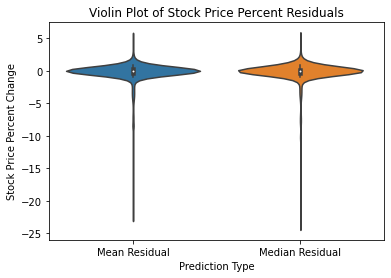

In [58]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([no_outliers_mean, no_outliers_median], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

In [59]:
stats.ttest_1samp(a=no_outliers_median, popmean=0).pvalue/2

0.0011165811457134014

In [60]:
stats.ttest_1samp(a=no_outliers_mean, popmean=0).pvalue/2

0.00045330492452277753

In [ ]:
# TODO: Look into how well financial analysts do in predicting stock price. Do they overshoot or undershoot?
# TODO: Calculate difference between actual and predicted stock price (usually 12 months into the future). 
# Need to figure out how to standardize this -> maybe divide difference by actual: (actual - predicted)/actual. 

# figure out how to do multiple linear regression


In [ ]:
# USE ALPHA VANTAGE to get missing entries?
# web.DataReader("BRK.A", "av-daily", start=datetime.datetime(2017, 2, 9), end=datetime.datetime(2017, 5, 24), api_key="")